<a href="https://colab.research.google.com/github/AndreasGeorgiou03/PINODEs/blob/main/PINODE_Exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [138]:
pip install torchdiffeq

In [139]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ============================================
# 1. Problem setup: 4-DOF shear building
# ============================================

# Parameters
k1 = k2 = k3 = k4 = 10.0
c1 = c2 = c3 = c4 = 0.5
m1 = m2 = m3 = m4 = 1.0
k_nl_true = 2.0  # cubic nonlinearity

# Mass matrix (all ones -> identity)
M = torch.eye(4, device=device)

# Stiffness matrix K for a 4-DOF shear building (fixed base)
K = torch.tensor([
    [k1 + k2,   -k2,       0.0,      0.0],
    [-k2,       k2 + k3,  -k3,       0.0],
    [0.0,      -k3,       k3 + k4,  -k4],
    [0.0,       0.0,      -k4,       k4]
], dtype=torch.float32, device=device)

# Damping matrix (diagonal with c1..c4)
C = torch.diag(torch.tensor([c1, c2, c3, c4], dtype=torch.float32, device=device))

# Initial conditions for this experiment: all zeros (forced vibration)
h0_train = torch.tensor([4, 0, 0, 0, 0, 0, 0, 0], dtype=torch.float32, device=device)


# Time grids
dt = 0.01  # 100 Hz
t_train_end = 4.0
t_test_end = 8.0  # e.g. extrapolate to 8 seconds

t_train = torch.linspace(0.0, t_train_end, int(t_train_end / dt) + 1, device=device)
t_test  = torch.linspace(0.0, t_test_end,  int(t_test_end  / dt) + 1, device=device)



Using device: cpu


In [140]:
# ============================================
# 2. Forcing: white-noise-like excitation u(t)
# ============================================

# We build a band-limited "white-noise-like" function u_base_fun(t)
# as a random Fourier series, then scale it with different amplitudes
# to create different excitation levels.

torch.manual_seed(0)

num_freqs = 50
freqs = torch.linspace(0.5, 20.0, num_freqs, device=device)
phases = 2.0 * math.pi * torch.rand(num_freqs, device=device)
coeffs = torch.randn(num_freqs, device=device) / math.sqrt(num_freqs)

def u_base_fun(t):

    t = t.to(device)
    # Shape (..., 1) for broadcasting
    t_exp = t.unsqueeze(-1)
    arg = 2.0 * math.pi * freqs * t_exp + phases  # shape (..., num_freqs)
    # sum over frequencies
    return (coeffs * torch.sin(arg)).sum(dim=-1)

# Forcing distribution applied at DOF 1
B_force = torch.tensor([1.0, 0.0, 0.0, 0.0], dtype=torch.float32, device=device)

# Amplitude levels
amplitudes_train = [5.0, 7.5, 10.0, 12.5]

In [141]:
# ============================================
# 3. Ground-truth dynamics (with forcing)
# ============================================

def make_ground_truth_rhs(amp):

    def rhs(t, h):
        x = h[:4]
        v = h[4:]

        # Linear restoring + damping
        lin_force = -K @ x - C @ v

        # Cubic nonlinearity on DOF 1 only
        f_nl = torch.zeros_like(x)
        f_nl[0] = -k_nl_true * x[0]**3

        # External forcing
        u_t = amp * u_base_fun(t)  # scalar
        f_u = B_force * u_t        # (4,)

        a = lin_force + f_nl + f_u  # since M = I

        dh = torch.zeros_like(h)
        dh[:4] = v
        dh[4:] = a
        return dh

    return rhs

@torch.no_grad()
def generate_trajectory(h0, t_grid, amp):

    rhs = make_ground_truth_rhs(amp)
    sol = odeint(rhs, h0, t_grid, method='rk4')
    return sol

print("Generating ground truth training data (white-noise excitation)...")
traj_train_list = []
for a in amplitudes_train:
    traj = generate_trajectory(h0_train, t_train, a)
    traj_train_list.append(traj)

# Example test case: unseen amplitude (extrapolation in input level)
amp_test = 8
traj_test_true = generate_trajectory(h0_train, t_test, amp_test)

Generating ground truth training data (white-noise excitation)...


In [142]:
# ============================================
# 4. PINODE schemes (physics + neural discrepancy)
# ============================================

class PINODEFuncScheme3(nn.Module):

    def __init__(self, K, C, B):
        super().__init__()
        self.K = nn.Parameter(K.clone(), requires_grad=False)
        self.C = nn.Parameter(C.clone(), requires_grad=False)
        self.B = nn.Parameter(B.clone(), requires_grad=False)
        self.amp = 1.0

        self.mlp = nn.Sequential(
            nn.Linear(8, 30),
            nn.Tanh(),
            nn.Linear(30, 4)
        )

    def forward(self, t, h):
        x = h[..., :4]
        v = h[..., 4:]

        dv_phys = (
            - self.K @ x.unsqueeze(-1)
            - self.C @ v.unsqueeze(-1)
        ).squeeze(-1)

        u_t = self.amp * u_base_fun(t)
        f_u = self.B * u_t
        dv_phys = dv_phys + f_u

        dv_corr = self.mlp(h)

        a = dv_phys + dv_corr

        dh = torch.zeros_like(h)
        dh[..., :4] = v
        dh[..., 4:] = a
        return dh

In [143]:
# ============================================
# 5. Discrepancy reference (with forcing)
# ============================================

def discrepancy_reference(x, v, t, scheme, K, C, k_nl, B, amp):

    # linear part Kx + Cv (T,4)
    lin = torch.matmul(x, K.T) + torch.matmul(v, C.T)

    # nonlinear force only on DOF1
    f_nl = torch.zeros_like(x)
    f_nl[:, 0] = k_nl * x[:, 0]**3

    # external forcing
    u_vals = amp * u_base_fun(t)          # (T,)
    f_u = u_vals.unsqueeze(-1) * B.unsqueeze(0)  # (T,4)

    # true acceleration
    a_true = -(lin + f_nl) + f_u

    if scheme == 1:
        a_phy = f_u
    elif scheme == 2:
        a_phy = -0.7 * lin + f_u
    elif scheme == 3:
        a_phy = -lin + f_u
    else:
        raise ValueError("scheme must be 1, 2, or 3")

    a_disc = a_true - a_phy
    return a_disc

def true_discrepancy_on_traj(scheme, traj, t_grid, amp):
    x = traj[..., :4]
    v = traj[..., 4:]
    return discrepancy_reference(
        x, v, t_grid,
        scheme=scheme, K=K, C=C,
        k_nl=k_nl_true, B=B_force, amp=amp
    )

In [144]:
# ============================================
# 6. Training utilities
# ============================================

def train_scheme_with_disc_multiamp_sequential(scheme,model,amplitudes,traj_list,num_epochs=2000,lr=1e-3,lambda_disc=1.0,):

    model = model.to(device)
    model.train()

    opt = optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    n_amps = len(amplitudes)
    assert n_amps == len(traj_list), "Mismatch: amplitudes and trajectory list lengths"

    # how many epochs per amplitude
    epochs_per_amp = num_epochs // n_amps
    leftover = num_epochs - epochs_per_amp * n_amps

    global_epoch = 0

    # loop over amplitudes
    for idx, (a, traj_true) in enumerate(zip(amplitudes, traj_list)):

        # last amplitude gets leftover epochs
        this_epochs = epochs_per_amp + (leftover if idx == n_amps - 1 else 0)

        print(f"\n=== Training on amplitude {a} for {this_epochs} epochs (scheme {scheme}) ===")

        for local_epoch in range(1, this_epochs + 1):
            global_epoch += 1
            opt.zero_grad()

            # FIX AMPLITUDE FOR THIS TRAJECTORY
            model.amp = float(a)

            # STATE LOSS (ODE rollout)
            pred = odeint(model, h0_train, t_train, method='rk4')
            loss_state = mse(pred, traj_true)

            # DISCREPANCY LOSS (NN correction vs physics discrepancy)
            with torch.no_grad():
                disc_true = true_discrepancy_on_traj(scheme, traj_true, t_train, a)

            disc_nn = model.mlp(traj_true)
            loss_disc = mse(disc_nn, disc_true)

            # TOTAL LOSS
            loss = loss_state + lambda_disc * loss_disc
            loss.backward()
            opt.step()

            # RESULTS EVERY 100 EPOCHS
            if global_epoch == 1 or global_epoch % 100 == 0:
                print(
                    f"[S{scheme}] Epoch {global_epoch:4d}, "
                    f"amp={a}, "
                    f"state={loss_state.item():.4e}, "
                    f"disc={loss_disc.item():.4e}, "
                    f"total={loss.item():.4e}"
                )

    return model

@torch.no_grad()
def evaluate_scheme_on_amp(scheme_name, model, amp_eval):
    """
    Evaluate a trained model on an unseen amplitude 'amp_eval' for 0–8s.
    """
    loss_fn = nn.MSELoss()
    model.amp = float(amp_eval)

    # Predict
    pred = odeint(model, h0_train, t_test, method='rk4')

    mse_full = loss_fn(pred, traj_test_true).item()

    # split at 4s
    mid_idx = len(t_train)  # since t_train ends at 4s with same dt
    mse_0_4  = loss_fn(pred[:mid_idx], traj_test_true[:mid_idx]).item()
    mse_4_8  = loss_fn(pred[mid_idx:], traj_test_true[mid_idx:]).item()

    print(f"\n=== Evaluation for {scheme_name} (amp = {amp_eval}) ===")
    print(f"MSE 0–8s  : {mse_full:.4e}")
    print(f"MSE 0–4s  : {mse_0_4:.4e}")
    print(f"MSE 4–8s  : {mse_4_8:.4e}")


def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Saved model to {path}")

In [145]:
# ============================================
# 7. Main: train all schemes (second experiment)
# ============================================

if __name__ == "__main__":

    # and that the folder exists.
    save_path = "/content/drive/MyDrive/pinode_models/"


    # Scheme 3
    # print("\n=== Training Scheme 3 (full K,C + forcing) ===")
    model3 = PINODEFuncScheme3(K, C, B_force)
    model3.load_state_dict(torch.load(save_path + "scheme_3_white_noise_exp2V3.pth", map_location=device))

    # model3 = train_scheme_with_disc_multiamp_sequential(scheme=3,model=model3,amplitudes=amplitudes_train,traj_list = traj_train_list, num_epochs=5000,lr=1e-3,lambda_disc=10.0)
    # evaluate_scheme_on_amp("Scheme 3", model3, amp_test)
    # save_model(model3, save_path + "scheme_3_white_noise_exp2V3.pth")

In [146]:
import matplotlib.pyplot as plt
import torch

def plot_x1_v1_a1(t, gt, pred, dt=0.01, save_path=None):

    # Extract x1 and v1
    x1_gt = gt[:, 0].detach().cpu()
    v1_gt = gt[:, 4].detach().cpu()

    x1_pr = pred[:, 0].detach().cpu()
    v1_pr = pred[:, 4].detach().cpu()

    # Numerical acceleration a1 via forward diff
    a1_gt = torch.diff(v1_gt) / dt
    a1_gt = torch.cat((a1_gt[:1], a1_gt), dim=0)  # pad to same length

    a1_pr = torch.diff(v1_pr) / dt
    a1_pr = torch.cat((a1_pr[:1], a1_pr), dim=0)

    # Plot
    plt.figure(figsize=(12, 9))

    # x1(t)
    plt.subplot(3, 1, 1)
    plt.plot(t.cpu(), x1_gt, 'k', lw=2, label="GT x1")
    plt.plot(t.cpu(), x1_pr, 'g--', lw=1.5, label="Pred x1")
    plt.ylabel("x1(t)")
    plt.grid(True)
    plt.legend()

    # v1(t)
    plt.subplot(3, 1, 2)
    plt.plot(t.cpu(), v1_gt, 'k', lw=2, label="GT v1")
    plt.plot(t.cpu(), v1_pr, 'g--', lw=1.5, label="Pred v1")
    plt.ylabel("v1(t)")
    plt.grid(True)
    plt.legend()

    # a1(t)
    plt.subplot(3, 1, 3)
    plt.plot(t.cpu(), a1_gt, 'k', lw=2, label="GT a1")
    plt.plot(t.cpu(), a1_pr, 'g--', lw=1.5, label="Pred a1")
    plt.ylabel("a1(t)")
    plt.xlabel("Time (s)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=250)

    plt.show()


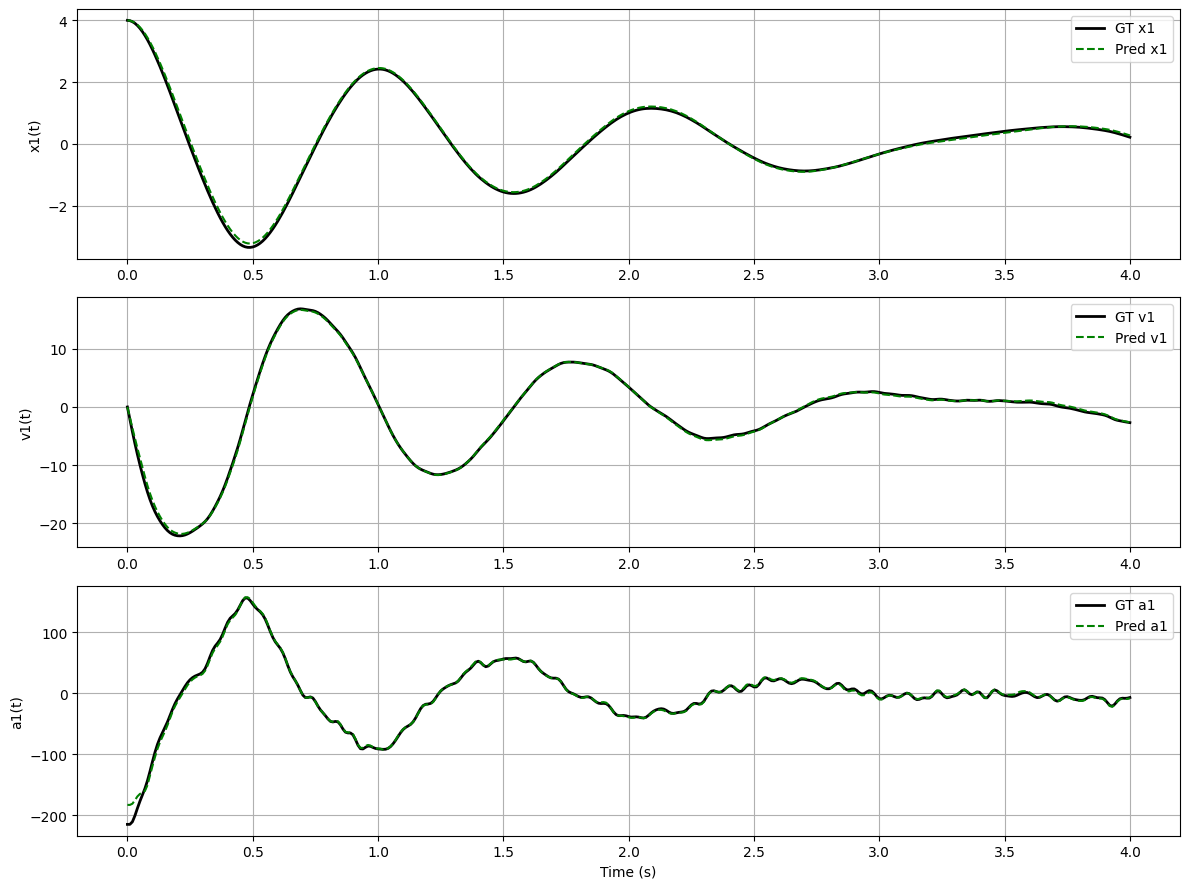

In [147]:
traj_gt = traj_train_list[0]
model3.amp = amplitudes_train[0]
traj_pred = odeint(model3, h0_train, t_train, method='rk4')

plot_x1_v1_a1(t_train, traj_gt, traj_pred, dt=dt)


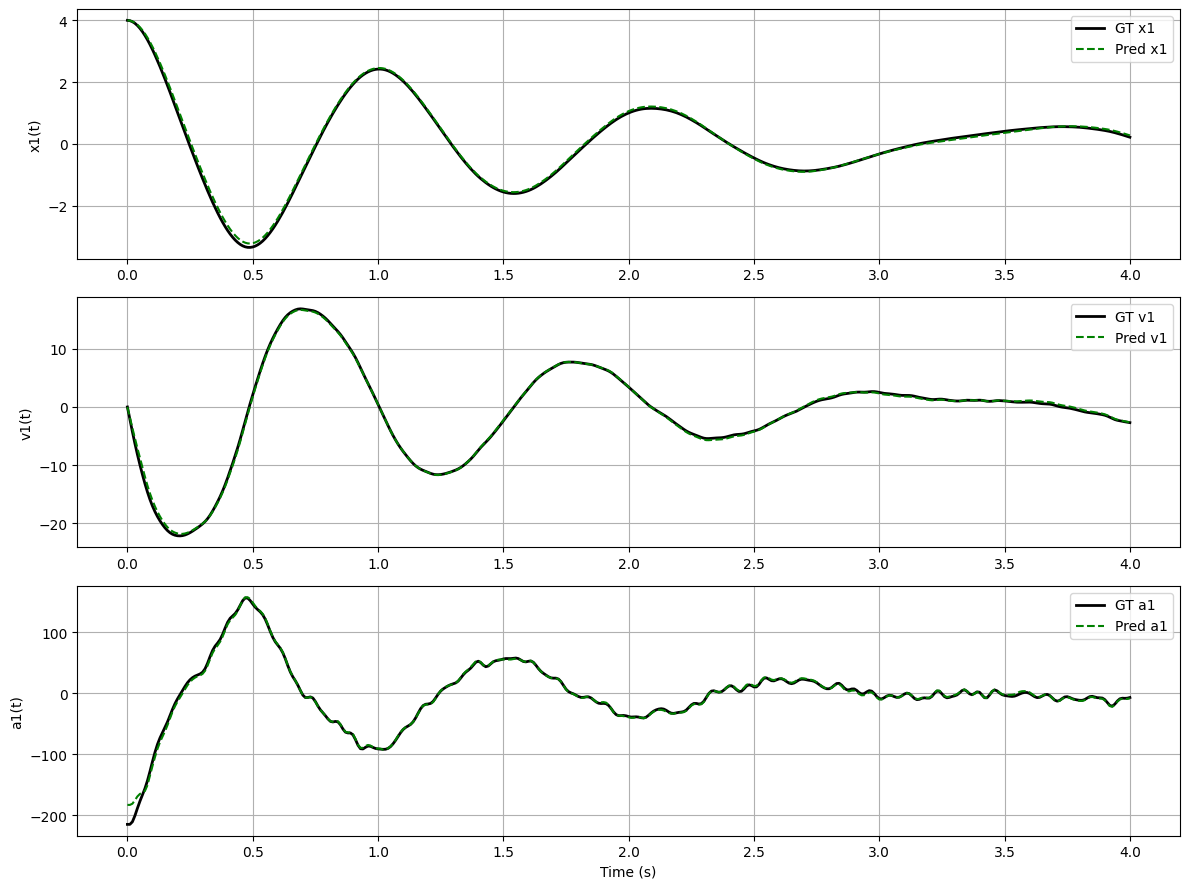

In [148]:
traj_gt = traj_train_list[0]
model3.amp = amplitudes_train[0]
traj_pred = odeint(model3, h0_train, t_train, method='rk4')

plot_x1_v1_a1(t_train, traj_gt, traj_pred, dt=dt)

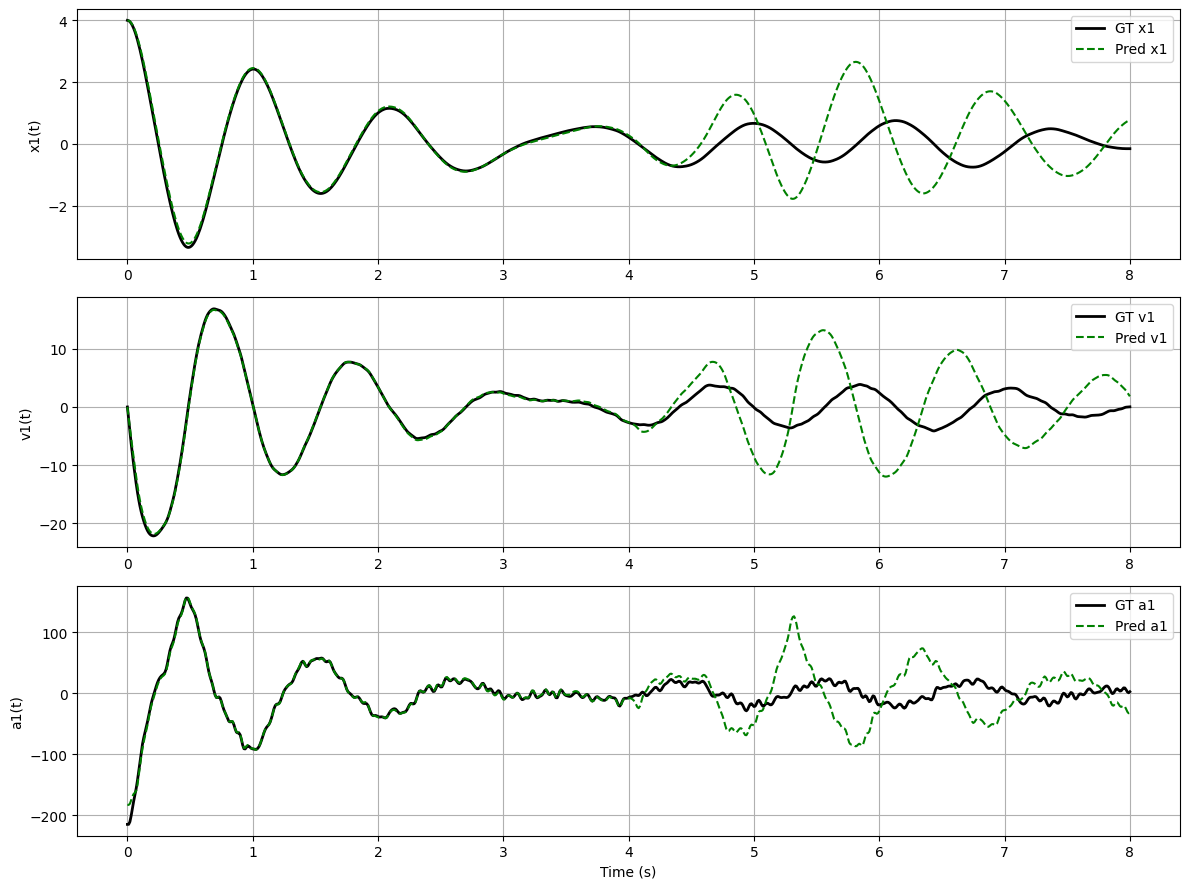

In [149]:
amp = amplitudes_train[0]
rhs = make_ground_truth_rhs(amp)

traj_gt = odeint(rhs, h0_train, t_test, method='rk4')
model3.amp = amp
traj_pred = odeint(model3, h0_train, t_test, method='rk4')

plot_x1_v1_a1(t_test, traj_gt, traj_pred, dt=dt)


In [150]:
pip install pysindy

In [151]:
import torch
import numpy as np
import pysindy as ps

def discrepancy_reference_exp2(x, v, t, scheme, K, C, k_nl, B, amp):

    # (T,4) linear part Kx + Cv
    lin = torch.matmul(x, K.T) + torch.matmul(v, C.T)

    # nonlinear force only on DOF 1
    f_nl = torch.zeros_like(x)
    f_nl[:, 0] = k_nl * x[:, 0]**3

    # external forcing: u(t) = amp * u_base_fun(t)
    # t is (T,), u_vals is (T,)
    u_vals = amp * u_base_fun(t)                  # <- use your u_base_fun
    f_u = u_vals.unsqueeze(-1) * B.unsqueeze(0)   # (T,4)

    # true acceleration
    a_true = -(lin + f_nl) + f_u

    if scheme == 1:
        a_phy = f_u
    elif scheme == 2:
        a_phy = -0.7 * lin + f_u
    elif scheme == 3:
        a_phy = -lin + f_u
    else:
        raise ValueError("scheme must be 1, 2, or 3")

    a_disc = a_true - a_phy
    return a_disc


In [152]:
def build_sindy_discrepancy_exp2(h_true_list,amp_list,scheme,K_true,C_true,k_nl_true,B_force,t_grid,device="cpu"):

    K = K_true.to(device)
    C = C_true.to(device)
    B = B_force.to(device)
    t_grid = t_grid.to(device)

    X_list = []
    Y_list = []

    for traj, amp in zip(h_true_list, amp_list):
        h_true = traj.to(device)   # (T,8)
        x = h_true[:, :4]
        v = h_true[:, 4:]

        # discrepancy for this trajectory & amplitude
        a_disc = discrepancy_reference_exp2(
            x, v, t_grid, scheme, K, C, k_nl_true, B, amp
        )  # (T,4)

        X_list.append(h_true)
        Y_list.append(a_disc)

    X_all = torch.cat(X_list, dim=0)
    Y_all = torch.cat(Y_list, dim=0)

    X = X_all.cpu().numpy()  # (N,8)
    Y = Y_all.cpu().numpy()  # (N,4)

    return X, Y


In [153]:
def run_sindy_discrepancy_exp2(h_true_list,amp_list,scheme,K_true,C_true,k_nl_true,B_force,t_grid,dt,threshold=0.05,device="cpu"):

    # Build data
    X, Y = build_sindy_discrepancy_exp2(
        h_true_list=h_true_list,
        amp_list=amp_list,
        scheme=scheme,
        K_true=K_true,
        C_true=C_true,
        k_nl_true=k_nl_true,
        B_force=B_force,
        t_grid=t_grid,
        device=device
    )
    # X: (N,8) state h = [x1..x4, v1..v4]
    # Y: (N,4) discrepancy accelerations

    # Polynomial library (like before)
    poly_lib = ps.PolynomialLibrary(
        degree=3,
        include_interaction=False,
        include_bias=False
    )

    # Optimizer
    optimizer = ps.STLSQ(threshold=threshold, alpha=1e-5, max_iter=100)

    # Fit 4 independent SINDy models, one per DOF discrepancy
    print(f"\n===== SINDy discrepancy equations for Scheme {scheme} (Experiment 2) =====")

    feature_names = ['x1','x2','x3','x4','v1','v2','v3','v4']

    for i in range(4):
        y_i = Y[:, i:i+1]   # (N,1)

        model = ps.SINDy(
            feature_library=poly_lib,
            optimizer=optimizer,
        )
        # t=dt is just a dummy here
        model.fit(X, t=dt, x_dot=y_i)

        coeffs = model.coefficients()[0]
        feats  = model.get_feature_names()

        print(f"\n--- dv{i+1}_disc ---")
        terms = []
        for c, term in zip(coeffs, feats):
            if abs(c) > 1e-4:
                terms.append(f"{c:+.5f} * {term}")
        if len(terms) == 0:
            print("   0")
        else:
            print("   dv{} = ".format(i+1) + " ".join(terms))


In [154]:
dt = 0.01

sindy_disc_s2 = run_sindy_discrepancy_exp2(h_true_list=traj_train_list,amp_list=amplitudes_train,scheme=3,K_true=K,C_true=C,k_nl_true=k_nl_true,B_force=B_force,t_grid=t_train,dt=dt,threshold=0.01,device=device)



===== SINDy discrepancy equations for Scheme 3 (Experiment 2) =====

--- dv1_disc ---
   dv1 = -2.00000 * x0^3

--- dv2_disc ---
   0

--- dv3_disc ---
   0

--- dv4_disc ---
   0


In [155]:
def build_sindy_discrepancy_from_nn_exp2(h_true_list, model, device="cpu"):

    # Concatenate all trajectories
    h_true = torch.cat(h_true_list, dim=0).to(device)   # (N,8)

    with torch.no_grad():
        a_disc_nn = model.mlp(h_true)                   # (N,4)

    X = h_true.cpu().numpy()
    Y = a_disc_nn.cpu().numpy()

    return X, Y


In [156]:
import pysindy as ps

def run_sindy_discrepancy_from_nn_exp2(h_true_list,model,dt,threshold=0.01,device="cpu"):


    # 1) Build X,Y from the trained neural net
    X, Y = build_sindy_discrepancy_from_nn_exp2(
        h_true_list=h_true_list,
        model=model,
        device=device
    )

    # 2) Same polynomial library as remainder of your code
    poly_lib = ps.PolynomialLibrary(
        degree=3,
        include_interaction=False,
        include_bias=False
    )

    # 3) Sparse optimizer
    optimizer = ps.STLSQ(threshold=threshold, alpha=1e-5, max_iter=100)

    print("\n===== SINDy discrepancy equations from NN (Scheme 3 — Experiment 2) =====")

    sindy_models = []
    for i in range(4):
        y_i = Y[:, i:i+1]   # column i

        model_sindy = ps.SINDy(
            feature_library=poly_lib,
            optimizer=optimizer,
        )

        # Fit SINDy using NN-produced derivative y_i
        model_sindy.fit(X, t=dt, x_dot=y_i)
        sindy_models.append(model_sindy)

        coeffs = model_sindy.coefficients()[0]
        feats  = model_sindy.get_feature_names()

        print(f"\n--- dv{i+1}_disc (NN) ---")
        terms = []
        for c, term in zip(coeffs, feats):
            if abs(c) > 1e-9:
                terms.append(f"{c:+.5f} * {term}")
        if not terms:
            print("   0")
        else:
            print("   dv{} = ".format(i+1) + " ".join(terms))

    return sindy_models


In [157]:
models_s3_nn = run_sindy_discrepancy_from_nn_exp2(h_true_list=traj_train_list,model=model3,dt=dt,threshold=0.5, device=device)



===== SINDy discrepancy equations from NN (Scheme 3 — Experiment 2) =====

--- dv1_disc (NN) ---
   dv1 = +2.26428 * x1 +3.61890 * x2 +4.16330 * x3 +0.62428 * x2^2 -0.73968 * x3^2 -1.80598 * x0^3

--- dv2_disc (NN) ---
   0

--- dv3_disc (NN) ---
   0

--- dv4_disc (NN) ---
   0


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(


In [158]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_restoring_force(gt, pred3, K, C, k_nl):

    # Ground truth
    x_gt = gt[:, :4]
    v_gt = gt[:, 4:]

    F_lin_gt = (x_gt @ K.T)[:, 0] + (v_gt @ C.T)[:, 0]
    F_nl_gt  = k_nl * x_gt[:, 0]**3
    F_gt     = (F_lin_gt + F_nl_gt).detach().cpu().numpy()
    x1_gt    = x_gt[:, 0].detach().cpu().numpy()

    # Only Scheme 3
    x_pr = pred3[:, :4]
    v_pr = pred3[:, 4:]

    F_lin_pr = (x_pr @ K.T)[:, 0] + (v_pr @ C.T)[:, 0]
    F_nl_pr  = k_nl * x_pr[:, 0]**3
    F_pr     = (F_lin_pr + F_nl_pr).detach().cpu().numpy()
    x1_pr    = x_pr[:, 0].detach().cpu().numpy()

    # Sort by x1 for plotting a smooth curve
    idx_gt = np.argsort(x1_gt)
    idx_pr = np.argsort(x1_pr)

    x1_gt, F_gt = x1_gt[idx_gt], F_gt[idx_gt]
    x1_pr, F_pr = x1_pr[idx_pr], F_pr[idx_pr]

    # Plot
    plt.figure(figsize=(6,6))
    plt.plot(x1_gt, F_gt, color="0.7", lw=2.5, label="Ground truth")
    plt.plot(x1_pr, F_pr, "k", lw=2.5, label="Scheme 3")

    plt.xlabel("displacement $x_1$")
    plt.ylabel("restoring force $F_1$")
    plt.title("Displacement Relation (DOF 1)")
    plt.grid(True)
    plt.legend()
    plt.show()


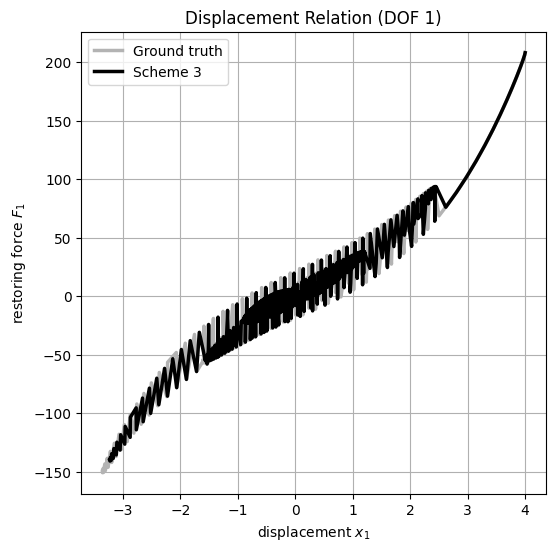

In [159]:
a_plot = amplitudes_train[0]
gt = generate_trajectory(h0_train, t_train, a_plot)
model3.amp = a_plot
pred = odeint(model3, h0_train, t_train)

plot_restoring_force(gt, pred, K, C, k_nl_true)